# Goal: Classify projects into different main categories

### Target: main_category
### Features: 
- goal
- time information (launch date, deadline)
- maybe name (we have to check if there's any valuable information that might come from the name of the project) 

### Business Understanding

Kickstarter campaigns can make ideas into reality. We want to explore if we can categorize a kickstart project into different classes by using its goals or name.
In that way, kickstarter would be able to categorize projects even if the creators forget to label them.

In [1]:
!pip install -U imbalanced-learn


     |████████████████████████████████| 174kB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 22.2MB 1.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


We start by importing numpy and pandas, two essential libraries for working with data in python

In [1]:
import pandas as pd
import numpy as np


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# reading the data
df_raw = pd.read_csv('ks-projects-201612.csv',encoding='latin1')

# setting the seed for reproducibility
np.random.seed(42)

/Users/sgdantas/miniconda/envs/multi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Exploring the data

In [6]:
df_raw.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [7]:
df_raw.shape

(323750, 17)

Notice that there's a trailing space in the columns' names, so we need to fix this first

In [14]:
df_raw.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [4]:
new_columns = [name.replace(' ','') for name in df_raw.columns]

In [5]:
new_columns

['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usdpledged',
 'Unnamed:13',
 'Unnamed:14',
 'Unnamed:15',
 'Unnamed:16']

In [6]:
df_raw.columns = new_columns

We are interested in answering the following question: can we classify a project into different categories based on their goal or using their name?

In order to do that, we will work with just a few columns

In [7]:
list(df_raw)

['ID',
 'name',
 'category',
 'main_category',
 'currency',
 'deadline',
 'goal',
 'launched',
 'pledged',
 'state',
 'backers',
 'country',
 'usdpledged',
 'Unnamed:13',
 'Unnamed:14',
 'Unnamed:15',
 'Unnamed:16']

In [8]:
df_raw = df_raw.loc[:,['name',
 'main_category',
 'deadline',
 'goal',
 'launched',]]

In [9]:
df_raw.isnull().sum()

name             4
main_category    0
deadline         0
goal             0
launched         0
dtype: int64

There are 4 projects with missing names, let's see if we can drop them

In [10]:
df_raw.loc[df_raw.name.isnull(),:]

,name,main_category,deadline,goal,launched
142830,NaN,Film & Video,2012-02-29 15:04:00,200000,2012-01-01 12:35:31
262901,NaN,Games,2013-01-06 23:00:00,2000,2012-12-19 23:57:48
265251,NaN,Design,2016-07-18 05:01:47,2500,2016-06-18 05:01:47
289847,NaN,Art,2011-12-05 05:59:00,35000,2011-11-06 23:55:55


In [11]:
df_raw.dropna(axis=0,how='any',inplace=True)
df_raw.shape

(323746, 5)

Since their categories are fairly common and their number very small when compared to the dataset, we will drop them. If they were from minority classes such as Dance or Journalism, we would probably want to keep them and add a 'missing' string as name

In [12]:
labels_distribution = df_raw.main_category.value_counts(normalize=True)
labels_distribution[:15]

Film & Video    0.178158
Music           0.144385
Publishing      0.105740
Games           0.086509
Technology      0.080705
Art             0.074052
Design          0.073734
Food            0.065573
Fashion         0.056829
Theater         0.030802
Photography     0.029900
Comics          0.027037
Crafts          0.022200
Journalism      0.012581
Dance           0.010425
Name: main_category, dtype: float64

We' re just going to consider the top 15 categories, the remaining categories are pretty uncommon

In [13]:
popular_cat_mask = df_raw.main_category.isin(labels_distribution[:15].index)
df_raw = df_raw.loc[popular_cat_mask,:]

The top 4 categories (Film & Video, Music, Publishing, Games) contain almost 50% of the projects

Parsing dates, we want to know the launching year/month and the duration (deadline - lunch)

In [38]:
pd.to_datetime(df_raw.launched,format= '%Y-%m-%d %H:%M:%S')

OutOfBoundsDatetime: ignored

We get an error when parsing the dates, let's see what's the problem

In [39]:
df_raw.launched.str.slice(0,4).value_counts()

2015    77180
2014    67602
2016    54494
2013    44755
2012    41088
        ...  
1600        1
3650        1
6857        1
6600        1
3550        1
Name: launched, Length: 65, dtype: int64

There are some incorrect dates

In [14]:
mask = (df_raw.launched.str.slice(0,4).astype(int) < 2009) | (df_raw.launched.str.slice(0,4).astype(int) > 2016)

In [15]:
df_raw.loc[mask,:]

,name,main_category,deadline,goal,launched
1794,The Beginners Guide to being Unsuicidal,Theater,USD,2011-12-31 23:25:46,5000
2443,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,2010-09-15 02:00:00,5000,1970-01-01 01:00:00
5813,Batman Dead End,Film & Video,USD,2013-03-28 15:03:32,12500
14446,Shade Tree Brewing Company,Food,USD,2012-02-03 18:19:09,15000
15945,Bea Arthur's bust,Art,USD,2015-07-11 05:24:29,13
...,...,...,...,...,...
319816,Building poverty stricken communities,Fashion,USD,2014-12-12 19:08:17,3210
319999,1024x768 {height:127px,Design,CAD,2014-08-10 21:02:48,16000
320631,A Vodcast on Green Tech and Society,Journalism,USD,2011-03-02 15:07:22,3000
322204,Feet on the Ground,Film & Video,USD,2013-04-17 16:00:31,35000


Some of the columns were swapped, but even if we swap them again we would still be missing information. We will also drop these rows

In [16]:
df_raw.drop(df_raw.loc[mask,:].index,inplace=True)

In [17]:
df_raw.shape

(323107, 5)

In [18]:
df_raw.launched.str.slice(0,4).value_counts()

2015    77180
2014    67602
2016    54494
2013    44755
2012    41088
2011    26173
2010    10491
2009     1324
Name: launched, dtype: int64

In [19]:
df_raw.reset_index(inplace=True, drop=True)


In [20]:
parse_launch_dates = pd.to_datetime(df_raw.launched,format= '%Y-%m-%d %H:%M:%S')
parse_deadline_dates = pd.to_datetime(df_raw.deadline,format= '%Y-%m-%d %H:%M:%S')

In [21]:
df_raw['year'] = parse_launch_dates.dt.year
df_raw['month'] = parse_launch_dates.dt.month

In [22]:
# duration of each project fundraising
df_raw['duration'] = (parse_deadline_dates - parse_launch_dates).dt.days

I believe the months themselves are not very informative, let's group by quarter

In [23]:
df_raw['quarter'] = df_raw.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',
                  7:'Q3',8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})

The data should be good to go now

In [24]:
df = df_raw[['name','goal','main_category','year','duration','quarter']]

In [25]:
df = df.astype({'goal':float,'duration':int,'year':int})

In [58]:
df.head()

,name,goal,main_category,year,duration,quarter
0,The Songs of Adelaide & Abullah,1000.0,Publishing,2015,58,Q3
1,Where is Hank?,45000.0,Film & Video,2013,45,Q1
2,ToshiCapital Rekordz Needs Help to Complete Album,5000.0,Music,2012,30,Q1
3,Community Film Project: The Art of Neighborhoo...,19500.0,Film & Video,2015,55,Q3
4,Monarch Espresso Bar,50000.0,Food,2016,35,Q1


We don't have that much information, so it's desirable to find a way to combine text and the remaining features.
That said, we should first see what we get by using just one "source" of data

### Dense features (goal,year,duration,quarter)

In [27]:
dense_cols = ['goal','main_category','year','duration','quarter']

In [28]:
df[['goal','main_category','duration','year']].groupby('main_category').describe()

goal                                                        \
                 count           mean           std   min       25%      50%   
main_category                                                                  
Art            23957.0   36414.736261  1.181736e+06  0.01  1000.000   3000.0   
Comics          8743.0   22910.229817  1.080410e+06  1.00  1500.000   3840.0   
Crafts          7182.0   11710.819618  1.300150e+05  1.00   644.125   2000.0   
Dance           3372.0    9719.983778  5.585464e+04  5.00  1500.000   3000.0   
Design         23863.0   49204.262956  1.008307e+06  1.00  4160.000  10000.0   
Fashion        18382.0   24751.340162  7.605822e+05  1.00  2000.000   6000.0   
Film & Video   57659.0   72992.073201  1.463894e+06  0.15  2500.000   6500.0   
Food           21198.0   50572.268969  1.027043e+06  1.00  3500.000  10000.0   
Games          28004.0   55624.263327  1.143162e+06  1.00  2800.000   8706.0   
Journalism      4069.0   95423.538285  2.322291e+06  1.00  1500.000   5000.0   
Music          46717.0   15312.614626  3.671866e+05  1.00  1600.000   4000.0   
Photography     9664.0   12719.892540  1.479436e+05  1.00  1500.000   4000.0   
Publishing     34220.0   30663.582261  1.170802e+06  0.01  2000.000   5000.0   
Technology     26116.0  116349.361663  1.747727e+06  1.00  5000.000  20000.0   
Theater         9961.0   26503.535248  5.496955e+05  1.00  1500.000   3000.0   

                                     duration             ...              \
                    75%          max    count       mean  ...   75%   max   
main_category                                             ...               
Art             7500.00  100000000.0  23957.0  32.806946  ...  35.0  91.0   
Comics          8475.00  100000000.0   8743.0  34.601739  ...  35.0  91.0   
Crafts          6500.00   10000000.0   7182.0  31.583821  ...  30.0  91.0   
Dance           6400.00    2000000.0   3372.0  32.856762  ...  36.0  91.0   
Design         30000.00  100000000.0  23863.0  34.441688  ...  40.0  91.0   
Fashion        15000.00  100000000.0  18382.0  32.913829  ...  35.0  92.0   
Film & Video   20000.00  100000000.0  57659.0  35.208745  ...  40.0  92.0   
Food           25000.00  100000000.0  21198.0  33.874516  ...  35.0  91.0   
Games          24711.25  100000000.0  28004.0  32.758285  ...  33.0  91.0   
Journalism     15000.00  100000000.0   4069.0  34.416073  ...  39.0  91.0   
Music           8500.00   50000000.0  46717.0  35.374403  ...  40.0  92.0   
Photography    10000.00   10000000.0   9664.0  33.817984  ...  36.0  91.0   
Publishing     10000.00  100000000.0  34220.0  33.911397  ...  35.0  91.0   
Technology     50000.00  100000000.0  26116.0  35.307321  ...  40.0  91.0   
Theater         7500.00   40000000.0   9961.0  33.440920  ...  38.0  92.0   

                  year                                                         \
                 count         mean       std     min     25%     50%     75%   
main_category                                                                   
Art            23957.0  2013.608173  1.724889  2009.0  2012.0  2014.0  2015.0   
Comics          8743.0  2013.872469  1.696781  2009.0  2013.0  2014.0  2015.0   
Crafts          7182.0  2014.590226  1.227898  2009.0  2014.0  2015.0  2015.0   
Dance           3372.0  2013.384045  1.736213  2009.0  2012.0  2014.0  2015.0   
Design         23863.0  2014.312869  1.432090  2009.0  2013.0  2015.0  2015.0   
Fashion        18382.0  2014.262376  1.428216  2009.0  2013.0  2015.0  2015.0   
Film & Video   57659.0  2013.216879  1.802210  2009.0  2012.0  2013.0  2015.0   
Food           21198.0  2014.211435  1.368444  2009.0  2014.0  2014.0  2015.0   
Games          28004.0  2014.268247  1.454998  2009.0  2013.0  2015.0  2015.0   
Journalism      4069.0  2014.202998  1.669049  2009.0  2014.0  2015.0  2015.0   
Music          46717.0  2013.227819  1.799777  2009.0  2012.0  2013.0  2015.0   
Photography     9664.0  2013.621378  1.731651  2009.0  2

The goal column seem to be the one with higher variability between different categories. The average duration and start year are very similar throughout the data. This lack of variability might indicate that these features are not very useful in classifying the projects into different categories 

In [71]:
sns.set(rc={'figure.figsize':(10,8)})

<AxesSubplot:xlabel='duration', ylabel='main_category'>

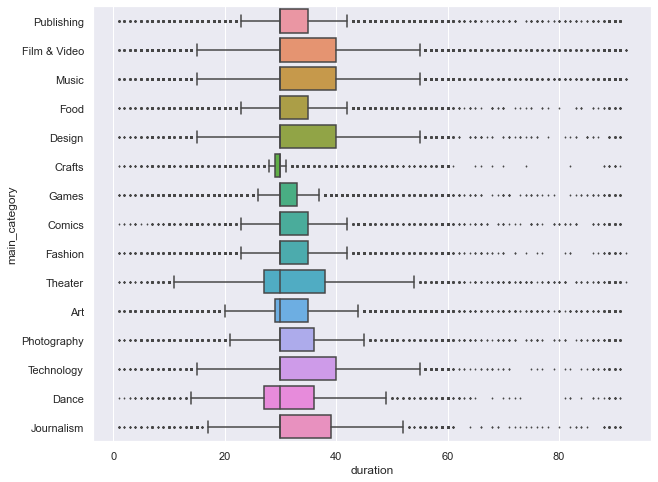

In [74]:
sns.boxplot(y=df.main_category,x=df.duration, orient='h',fliersize=1)

<AxesSubplot:xlabel='year', ylabel='main_category'>

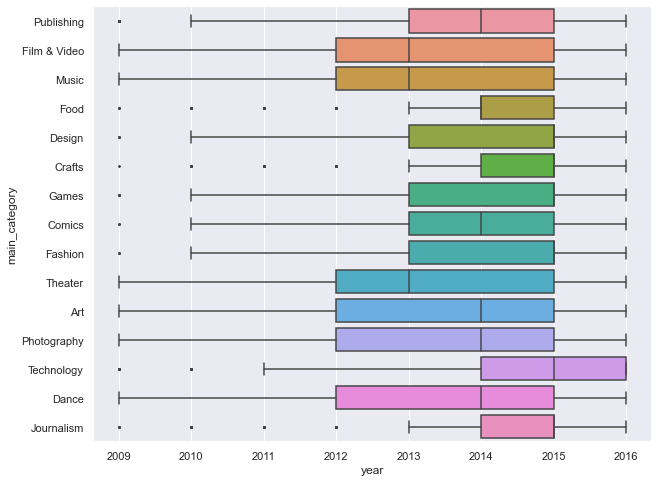

In [73]:
sns.boxplot(y=df.main_category,x=df.year, orient='h',fliersize=1)

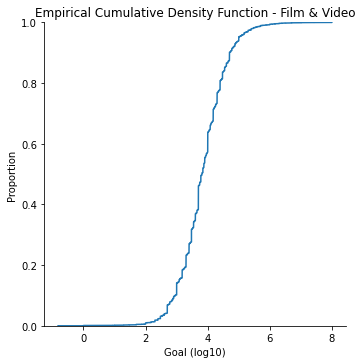

In [55]:
sns.displot(np.log10(df.goal[df.main_category=='Film & Video']), kind="ecdf")
plt.xlabel('Goal (log10)')
plt.title('Empirical Cumulative Density Function - Film & Video')
plt.show()

In [ ]:
sns.hist(df.goal[df.main_category=='Journalism'])

In [ ]:
def prepare_data(df:pd.DataFrame,
                 target_col:str='main_category',
                 feat_type:str='dense'):
    """
    prepare the data for classifying
    support dense, text or a combination of both features
    """

    y = df[target_col]

    if feat_type == 'dense':
        feat_cols = ['goal','year','duration','quarter']
        column_trans = ColumnTransformer(
        [('year', OneHotEncoder(dtype='int'),['year']),
        ('quarter', OneHotEncoder(dtype='int'),['quarter']),
        ('goal', StandardScaler(), ['goal']),
        ('duration', StandardScaler(), ['duration'])],
        remainder='passthrough')
    elif feat_type == 'text':
        feat_cols = 'name'
        column_trans = TfidfVectorizer(max_features=5000)

    elif feat_type =='both':
        feat_cols = ['goal','year','duration','quarter','name']
        column_trans = ColumnTransformer(
        [('year', OneHotEncoder(dtype='int'),['year']),
        ('quarter', OneHotEncoder(dtype='int'),['quarter']),
        ('goal', StandardScaler(), ['goal']),
        ('duration', StandardScaler(), ['duration']),
        ('name',TfidfVectorizer(max_features=5000),'name')],
        remainder='passthrough')


    X = df[feat_cols]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,
                                                        random_state=42)
    X_train = column_trans.fit_transform(X_train)
    X_test = column_trans.transform(X_test)

    label_enc = LabelEncoder()
    y_train = label_enc.fit_transform(y_train)
    y_test = label_enc.transform(y_test)

    train_data = (X_train, y_train)
    test_data = (X_test, y_test)

    return train_data,test_data

In [ ]:
train_data,test_data = prepare_data(df.copy())

In [ ]:
(X_train, y_train) = train_data
(X_test, y_test) = test_data

Since the data is fairly imbalanced, we try the "vanilla" logistic regression and also a logistic regression with a loss function that penalizes each error according to its true classification frequency

In [ ]:
clf = LogisticRegression(max_iter=1000).fit(X_train,y_train)
clf_bal = LogisticRegression(max_iter=1000,class_weight='balanced').fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)
y_pred_bal = clf_bal.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4757
           1       0.00      0.00      0.00      1689
           2       0.00      0.00      0.00      1494
           3       0.00      0.00      0.00       679
           4       0.00      0.00      0.00      4785
           5       0.00      0.00      0.00      3683
           6       0.19      0.83      0.32     11620
           7       0.00      0.00      0.00      4266
           8       0.15      0.07      0.10      5530
           9       0.00      0.00      0.00       809
          10       0.27      0.02      0.04      9368
          11       0.00      0.00      0.00      1934
          12       0.00      0.00      0.00      6857
          13       0.14      0.30      0.19      5191
          14       0.00      0.00      0.00      1960

    accuracy                           0.18     64622
   macro avg       0.05      0.08      0.04     64622
weighted avg       0.10   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred))

0.08207679099087468


In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred_bal))

0.11811940922879335


In [ ]:
print(metrics.classification_report(y_test,y_pred_bal))

              precision    recall  f1-score   support

           0       0.19      0.00      0.00      4757
           1       0.04      0.01      0.02      1689
           2       0.04      0.47      0.08      1494
           3       0.02      0.06      0.03       679
           4       0.11      0.02      0.03      4785
           5       0.00      0.00      0.00      3683
           6       0.32      0.07      0.12     11620
           7       0.11      0.21      0.14      4266
           8       0.14      0.06      0.09      5530
           9       0.02      0.08      0.03       809
          10       0.24      0.19      0.21      9368
          11       0.03      0.02      0.02      1934
          12       0.14      0.06      0.09      6857
          13       0.16      0.27      0.20      5191
          14       0.06      0.25      0.09      1960

    accuracy                           0.11     64622
   macro avg       0.11      0.12      0.08     64622
weighted avg       0.17   

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [ ]:
clf_und = LogisticRegression(max_iter=1000).fit(X_res, y_res)
y_pred_und = clf_und.predict(X_test)

In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred_und))

0.11538331556971786


In [ ]:
print(metrics.classification_report(y_test,y_pred_und))

              precision    recall  f1-score   support

           0       0.05      0.00      0.00      4757
           1       0.04      0.01      0.02      1689
           2       0.04      0.41      0.08      1494
           3       0.02      0.05      0.02       679
           4       0.10      0.05      0.06      4785
           5       0.06      0.00      0.00      3683
           6       0.33      0.07      0.12     11620
           7       0.10      0.22      0.14      4266
           8       0.12      0.13      0.13      5530
           9       0.02      0.03      0.02       809
          10       0.25      0.22      0.23      9368
          11       0.00      0.00      0.00      1934
          12       0.03      0.00      0.00      6857
          13       0.15      0.32      0.21      5191
          14       0.06      0.21      0.09      1960

    accuracy                           0.12     64622
   macro avg       0.09      0.12      0.08     64622
weighted avg       0.15   

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

clf_bb = BalancedBaggingClassifier(
        base_estimator=HistGradientBoostingClassifier(random_state=42),
        n_estimators=100, random_state=42, n_jobs=2
    ).fit(X_train.A,y_train)



In [ ]:
y_pred_bb = clf_bb.predict(X_test.A)
print(metrics.classification_report(y_test,y_pred_bb))

              precision    recall  f1-score   support

           0       0.14      0.03      0.05      4757
           1       0.06      0.17      0.09      1689
           2       0.06      0.41      0.11      1494
           3       0.02      0.19      0.04       679
           4       0.16      0.16      0.16      4785
           5       0.09      0.03      0.05      3683
           6       0.39      0.15      0.22     11620
           7       0.16      0.14      0.15      4266
           8       0.17      0.07      0.10      5530
           9       0.03      0.12      0.05       809
          10       0.28      0.14      0.19      9368
          11       0.06      0.03      0.04      1934
          12       0.16      0.06      0.09      6857
          13       0.24      0.41      0.30      5191
          14       0.07      0.20      0.11      1960

    accuracy                           0.14     64622
   macro avg       0.14      0.16      0.12     64622
weighted avg       0.21   

In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred_bb))

0.1557064413899569


In [ ]:
X_test.shape

(64622, 14)

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical

def NN_model(n_features:int, n_labels:int):
    """
    define a feedforward NN using keras
    """

    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(25))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.1))
    model.add(Dense(n_labels, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model
    

In [ ]:
def fit_predict_imbalanced_model(
    X_train:np.array, y_train:np.array, X_test:np.array):
    """
    train a NN defined by keras, return its predictions
    """
    model = NN_model(X_train.shape[1],15)
    y_train = to_categorical(y_train)
    model.fit(X_train, y_train, epochs=50, verbose=1, batch_size=1000)
    y_pred = model.predict(X_test, batch_size=1000)
    return np.argmax(y_pred,axis=1)



In [ ]:
y_nn = fit_predict_imbalanced_model(X_train, y_train, X_test)

Epoch 1/50
259/259 [==============================] - 4s 6ms/step - loss: 2.6701 - accuracy: 0.1316
Epoch 2/50
259/259 [==============================] - 2s 6ms/step - loss: 2.4385 - accuracy: 0.1726
Epoch 3/50
259/259 [==============================] - 2s 6ms/step - loss: 2.4202 - accuracy: 0.1769
Epoch 4/50
259/259 [==============================] - 2s 6ms/step - loss: 2.4144 - accuracy: 0.1792
Epoch 5/50
259/259 [==============================] - 2s 6ms/step - loss: 2.4079 - accuracy: 0.1812
Epoch 6/50
259/259 [==============================] - 2s 6ms/step - loss: 2.4019 - accuracy: 0.1825
Epoch 7/50
259/259 [==============================] - 2s 6ms/step - loss: 2.3973 - accuracy: 0.1850
Epoch 8/50
259/259 [==============================] - 2s 6ms/step - loss: 2.3939 - accuracy: 0.1869
Epoch 9/50
259/259 [==============================] - 2s 6ms/step - loss: 2.3870 - accuracy: 0.1903
Epoch 10/50
259/259 [==============================] - 2s 6ms/step - loss: 2.3757 - accuracy: 0.1936

In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_nn))

0.09488402574162681


In [ ]:
print(metrics.classification_report(y_test,y_nn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4757
           1       0.00      0.00      0.00      1689
           2       0.00      0.00      0.00      1494
           3       0.00      0.00      0.00       679
           4       0.00      0.00      0.00      4785
           5       0.00      0.00      0.00      3683
           6       0.23      0.68      0.34     11620
           7       0.00      0.00      0.00      4266
           8       0.00      0.00      0.00      5530
           9       0.00      0.00      0.00       809
          10       0.00      0.00      0.00      9368
          11       0.00      0.00      0.00      1934
          12       0.00      0.00      0.00      6857
          13       0.13      0.74      0.22      5191
          14       0.00      0.00      0.00      1960

    accuracy                           0.18     64622
   macro avg       0.02      0.09      0.04     64622
weighted avg       0.05   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We've tried different classifiers (logistic regression, tree-based classifier and NN) and an undersampling technique. The results were pretty underwhelming for all cases, which confirms our hypothesis that these features are not really informative for classifying the projects

### Text features

Now, let's try to use the name of each project as features. We do this by using a TF-IDF vectorizer. One might also use word embeddings instead of vectorizer, but I decided to use vectorizers as our texts are pretty short and fairly specific.

In [ ]:
train_data,test_data = prepare_data(df.copy(),feat_type='text')
(X_train, y_train) = train_data
(X_test, y_test) = test_data

In [ ]:
clf = LogisticRegression(max_iter=1000).fit(X_train,y_train)
clf_bal = LogisticRegression(max_iter=1000,class_weight='balanced').fit(X_train,y_train)

In [ ]:
y_pred = clf.predict(X_test)
y_pred_bal = clf_bal.predict(X_test)

In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred))

0.4887152232362485


In [ ]:
print(metrics.balanced_accuracy_score(y_test,y_pred_bal))

0.5312612956801293


In [ ]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49      4792
           1       0.81      0.43      0.56      1641
           2       0.55      0.28      0.37      1431
           3       0.77      0.38      0.51       657
           4       0.52      0.48      0.50      4697
           5       0.71      0.60      0.65      3715
           6       0.47      0.75      0.57     11588
           7       0.74      0.72      0.73      4256
           8       0.65      0.61      0.63      5586
           9       0.39      0.06      0.10       805
          10       0.77      0.76      0.77      9377
          11       0.63      0.37      0.46      1870
          12       0.54      0.51      0.52      6902
          13       0.57      0.54      0.55      5245
          14       0.66      0.40      0.50      2060

    accuracy                           0.59     64622
   macro avg       0.62      0.49      0.53     64622
weighted avg       0.61   

In [ ]:
print(metrics.classification_report(y_test,y_pred_bal))

              precision    recall  f1-score   support

           0       0.56      0.40      0.47      4792
           1       0.35      0.57      0.43      1641
           2       0.25      0.47      0.33      1431
           3       0.17      0.54      0.26       657
           4       0.52      0.45      0.48      4697
           5       0.67      0.61      0.64      3715
           6       0.59      0.50      0.54     11588
           7       0.69      0.74      0.72      4256
           8       0.65      0.60      0.62      5586
           9       0.09      0.40      0.15       805
          10       0.88      0.69      0.78      9377
          11       0.30      0.52      0.38      1870
          12       0.59      0.40      0.48      6902
          13       0.58      0.52      0.55      5245
          14       0.35      0.55      0.43      2060

    accuracy                           0.54     64622
   macro avg       0.48      0.53      0.48     64622
weighted avg       0.60   

The results obtained using the names of the projects as features are significantly better than the ones we got by just using the "dense" features. Let's see what we get by combining both of them

The results of the NN are similar to the ones obtained by the logistic regression. So, we would choose the logistic regression as it's cheaper to train/predict and more interpretable

There is a lot of room for improvement, some suggestions to improve the performance are:

- use a gridsearch to optimize the hyperparameters of the models (regularization for the logistic regression, architecture, learning rate, dropout rate, etc for the NN)
- cross-validate the results using different data splits
- try to use a dimensionality reduction technique (such as LSA) on the features obtained by the TF-IDF and then combine these new features with the "dense" features
- use the output probabilities of the text-only model as features to combine with the "dense" features, then train a new model using these features